In [1]:
# initialise the model as in init_snn1.ipynb
# start manually feeding in sequences, calculating loss and backpropagating
# observe underlying changes in weights
# trying to answer the questions:
# - how does the transition towards stereotypical weight matrix occur
# - what are the changes to the distribution of weights and biases
# - what is the effect of learning rate magnitude
# - what happens if you only feed in sequences starting from a single digit
# - what is the effect of redefining the loss function (e.g. only over digit presentations)

In [ ]:
# - investigate in which cases do NaNs appear
# - investigate why does clipping not work

In [ ]:
# TODO
# - implement full optimisation loop (batching through the whole dataset)

In [2]:
import sys
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from models import get_model
from datasets import MNISTSequencesDataset, NormaliseToZeroOneRange

from SNNCustomConfig import SNNCustomConfig

Matplotlib created a temporary cache directory at /tmp/matplotlib-s_xf7138 because the default path (/home/jupyter-ikharitonov/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
torch.manual_seed(0)
np.random.seed(0)

ingest_torch_dtype = torch.uint8
ingest_numpy_dtype = np.uint8

dtype = torch.float32

config = SNNCustomConfig(model_name="SNN1", dataset_name="mnist_sequences_250hz", configuration_name="config0_test")
print(config.params)

ConfigParser: Configuration file was not provided. Using default configuration for "SNN1_mnist_sequences_250hz".
{'dataset_sampling_frequency': 10, 'LIF_linear_features': 784, 'reset_mechanism': 'subtract', 'init_type': 'pure', 'grad_clipping': 'true', 'grad_clipping_max_norm': 1, 'membrane_time_constant_tao': 0.03, 'synaptic_time_constant_tao': 0.03, 'rheobase_multiplier': 0.13, 'rheobase_apply': 'true', 'input_multiplier': 1, 'torch_device': 'cuda', 'batch_size': 20, 'iterations': 1, 'epochs': 100, 'loss_type': 'L1Loss', 'loss_subtype': 'preactivation', 'optimiser_type': 'Adam', 'optimiser_learning_rate': 0.0005, 'optimiser_momentum': 0.9, 'optimiser_weight_decay': 0.006, 'dataloader_num_workers': 36, 'dataloader_pin_memory': True, 'scheduler_type': 'WarmupCosineLR', 'scheduler_StepLR_step_size': 5, 'scheduler_StepLR_gamma': 0.25, 'scheduler_WarmupCosineLR_warmup_factor': 0.001, 'scheduler_WarmupCosineLR_warmup_iterations': 3, 'scheduler_CosineAnnealingWarmRestarts_restart_period': 1

In [4]:
tao_mem = 0.03
timestep = 1/250
beta = np.exp(-timestep / tao_mem)

device = torch.device(config.params["torch_device"])

normalise_transform = NormaliseToZeroOneRange(dtype=dtype)
mnist_dataset = MNISTSequencesDataset(config.dirs["training"], config.params["LIF_linear_features"], ingest_numpy_dtype, ingest_torch_dtype, transform=normalise_transform)
train_loader = DataLoader(mnist_dataset, batch_size=config.params["batch_size"], shuffle=False, num_workers=config.params["dataloader_num_workers"])

In [5]:
config.data_shape = next(iter(train_loader)).shape

model_class = get_model(config.model_name)
model = model_class(num_steps=config.data_shape[1], beta=beta, alpha=1, LIF_linear_features=config.params["LIF_linear_features"], reset_mechanism=config.params["reset_mechanism"], dtype=dtype).to(device).to(dtype)

In [6]:
random_data = next(iter(train_loader)).to(device) * config.params['rheobase_multiplier'] * config.params['input_multiplier']

In [7]:
# model.eval()
# spk_rec, mem_rec = model(random_data)

# random_data = random_data.detach().cpu().numpy()
# spk_rec = spk_rec.detach().cpu().numpy()
# mem_rec = mem_rec.detach().cpu().numpy()

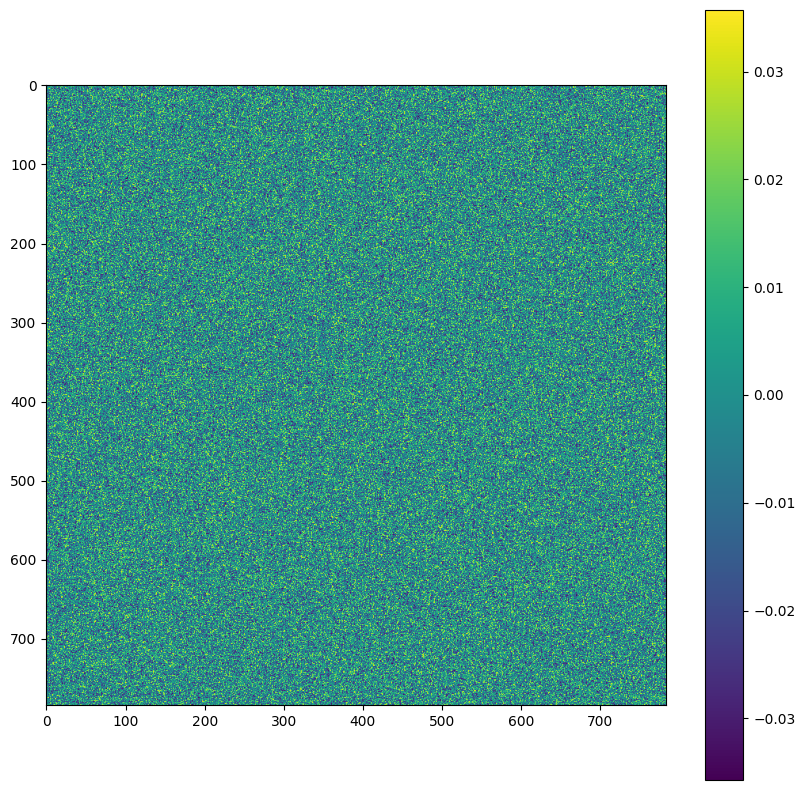

In [8]:
plt.figure(figsize=(10,10))
plt.imshow(model.lif1.recurrent.weight.data.detach().cpu().numpy())
plt.colorbar()
plt.show()

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay =0.006, betas=(0.9,0.999))
loss_fn = nn.L1Loss()
loss_hist = []
weight_matrix_snapshots = []

for i in range(300):
    optimizer.zero_grad(set_to_none=True)
    
    spk_rec, mem_rec = model(random_data)
    loss_val = loss_fn(mem_rec, torch.zeros_like(mem_rec))
    
    loss_val.backward()
    optimizer.step()
    
    # store loss value
    loss_hist.append(loss_val.item())
    print(i, loss_val.item())
    
    weight_matrix_snapshots.append(model.lif1.recurrent.weight.data.detach().cpu().numpy())

0 0.18605303764343262
1 0.18376313149929047
2 0.18138189613819122
3 0.1790214627981186
4 0.17665991187095642
5 0.1744326949119568
6 0.17231175303459167
7 0.17030483484268188
8 0.16856664419174194
9 0.16739147901535034
10 0.16704635322093964
11 0.16673065721988678
12 0.1670876443386078
13 0.1679144650697708
14 0.1674293577671051
15 0.16713282465934753
16 0.16687121987342834
17 0.16665999591350555
18 0.16648191213607788
19 0.16635383665561676
20 0.16625389456748962
21 0.16615910828113556
22 0.1661256104707718
23 0.16605623066425323
24 0.16604149341583252
25 0.16600431501865387
26 0.16599002480506897
27 0.16597652435302734
28 0.16594520211219788
29 0.1659594029188156
30 0.16592033207416534
31 0.16592144966125488
32 0.16590410470962524
33 0.1659039407968521
34 0.16587671637535095
35 0.1658812165260315
36 0.16584698855876923
37 0.1658574640750885
38 0.16582795977592468
39 0.16580542922019958
40 0.16579295694828033
41 0.16577403247356415
42 0.16575226187705994
43 0.16574536263942719
44 0.165

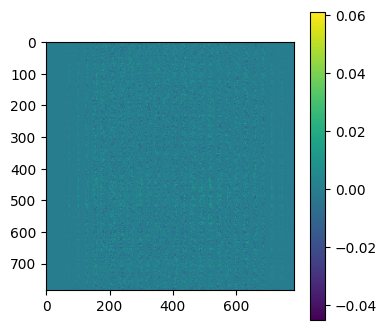

In [10]:
plt.figure(figsize=(4,4))
plt.imshow(weight_matrix_snapshots[98])
plt.colorbar()
plt.show()

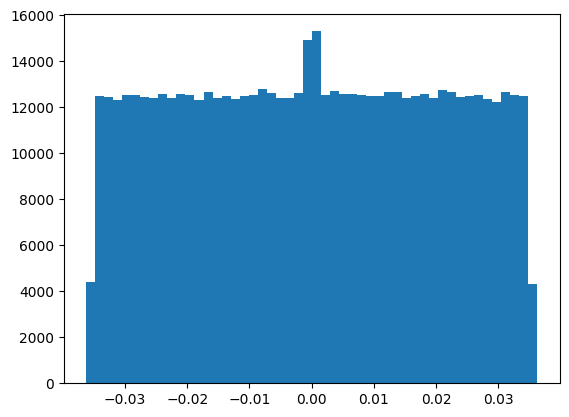

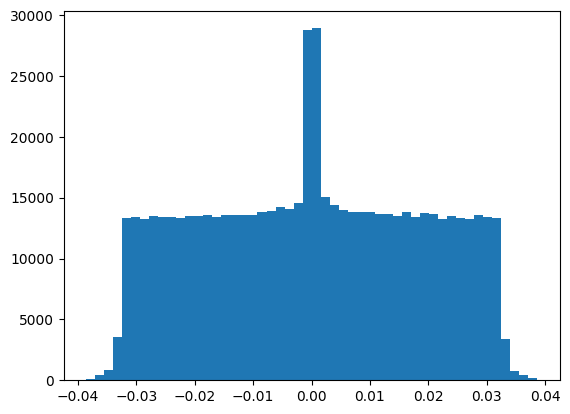

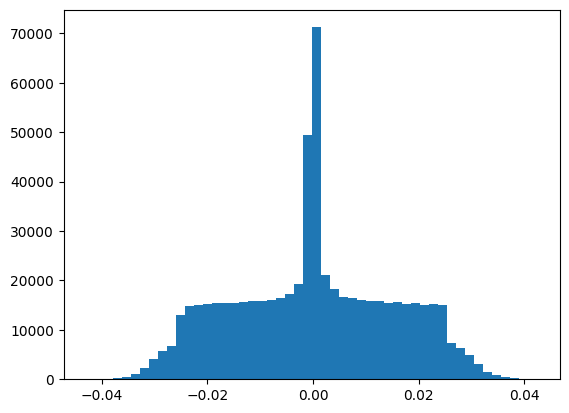

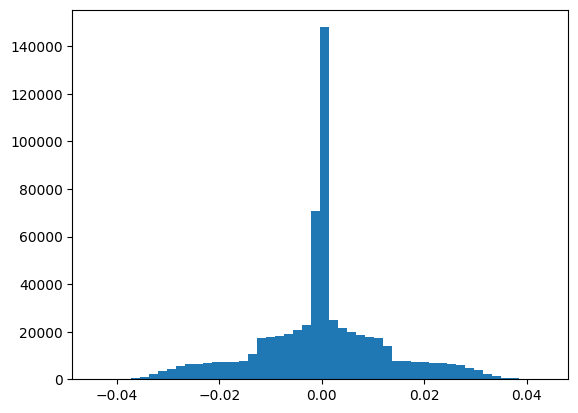

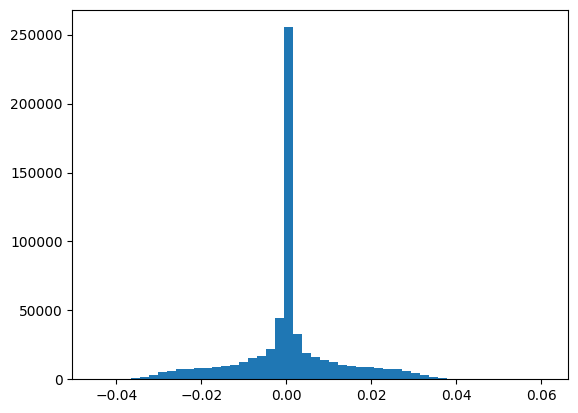

In [14]:
plt.hist(weight_matrix_snapshots[0].flatten(),bins=50)
plt.show()
plt.hist(weight_matrix_snapshots[5].flatten(),bins=50)
plt.show()
plt.hist(weight_matrix_snapshots[20].flatten(),bins=50)
plt.show()
plt.hist(weight_matrix_snapshots[50].flatten(),bins=50)
plt.show()
plt.hist(weight_matrix_snapshots[98].flatten(),bins=50)
plt.show()